# Titanic Kaggle Competition  - data cleaning

The Titanic dataset contains tabular data of Titanic passengers. The features are:

-  ticket Class (1, 2, 3),
-  passenger name,
-  sex,
-  age (**some data missing**),
-  no. of siblings or spouses aboard the ship,
-  no. of parents or children aboard the ship,
-  ticket number (alphanumerical),
-  passenger fare,
-  cabin number (letter denoting the deck followed by number, **lots of data missing**),
-  port of embarkation (C = Cherbourg, Q = Queenstown, S = Southampton).

As you can see, some data cleaning is needed because of the missing data as well as due to the format of some of the data.

First we load some necessary libraries.


In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder

Next, we load the data and print first few enrtries.

In [2]:
train_data=pd.read_csv('train.csv')
test_data=pd.read_csv('test.csv')
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
print("Train data info:")
train_data.info()
print("Test data info:")
test_data.info()
print("Train data shape:\t" + str(train_data.shape) )
print("Test data shape:\t" + str(test_data.shape) )

Train data info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
Test data info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 

## Cabin data

Just by looking at the above info we can tell that the "Cabin" column has many missing entries. Thus, we will simply replace the missing values by a new value called "Deck_NA". In fact, we will be ignoring the cabin number and instead from the cabin data we will extract two features:
-  the letter denoting the deck (A, B, C, D, E, F, T, G, Deck_NA)
-  the number of cabins booked by the given passenger (1 if unknown).

In [4]:
def extract_cabin_quantity(data):
    return data['Cabin'].apply( lambda c: len(str(c).split(' ')) if c!=np.nan else 0 )

def extract_deck(data):
    return data['Cabin'].apply( lambda cabin: 'Deck_'+str(cabin)[0] if cabin!=np.nan else 'Deck_NA' )

In [5]:
train_data["No_Cabins"] = extract_cabin_quantity(train_data)
test_data["No_Cabins"] = extract_cabin_quantity(test_data)
train_data['Cabin'] = extract_deck(train_data)
test_data['Cabin'] = extract_deck(test_data)

Let us next see the value statistics for the new Cabin column.

In [6]:
print("Train data:")
print( train_data.Cabin.value_counts() )
print("\nTest data:")
print( test_data.Cabin.value_counts() )

Train data:
Cabin
Deck_n    687
Deck_C     59
Deck_B     47
Deck_D     33
Deck_E     32
Deck_A     15
Deck_F     13
Deck_G      4
Deck_T      1
Name: count, dtype: int64

Test data:
Cabin
Deck_n    327
Deck_C     35
Deck_B     18
Deck_D     13
Deck_E      9
Deck_F      8
Deck_A      7
Deck_G      1
Name: count, dtype: int64


Next, we one-hot encode the deck letter.

In [7]:
def one_hot(data, ft_name):
    """
    Replaces feature ft_name with its one-hot encoded columns.
    """
    one_hot = pd.get_dummies(data[ft_name], dtype=int)
    data=data.drop(ft_name, axis=1)
    
    return data.join(one_hot)

In [8]:
train_data=one_hot(train_data, 'Cabin')
test_data=one_hot(test_data, 'Cabin')

"""
    We drop Deck_T column since there is just one person on deck T in the 
    training data and no people on deck T in the test data.
"""
train_data=train_data.drop('Deck_T', axis=1)

We are now done with the Cabin feature. The next feature with a significant number of missing values is Age. However, before we deal with this, let us work on the Name column.

## Name column

We will follow the popular practice of dealing with the Name column, namely we will extract titles from it. Title can be an informative feature, as it says a lot about the social status of the passenger.

In [9]:
def extract_title(data):
    """
    Title is always the second word of the Name.
    """
    return data.Name.apply(lambda name: name.split(',')[1].split('.')[0].strip())

In [10]:
train_data['Title'] = extract_title(train_data)
test_data['Title'] = extract_title(test_data)

Let us have a look at the values of the Title column.

In [11]:
print( "Train data:")
print( pd.concat([train_data, test_data]).Title.value_counts() )

Train data:
Title
Mr              757
Miss            260
Mrs             197
Master           61
Rev               8
Dr                8
Col               4
Mlle              2
Major             2
Ms                2
Lady              1
Sir               1
Mme               1
Don               1
Capt              1
the Countess      1
Jonkheer          1
Dona              1
Name: count, dtype: int64


We can see that there is quite a lot of variability. Let us normalise the titles according to their meanings. We will mostly merge male and female titles as the same info is contained in the Sex column. We keep the titles that may indicate age.

In [12]:
normalized_titles = {
    "Capt":       "Mid_rank",
    "Col":        "Mid_rank",
    "Major":      "Mid_rank",
    "Jonkheer":   "Nobility",
    "Don":        "Nobility",
    "Sir" :       "Nobility",
    "Dr":         "Mid_rank",
    "Rev":        "Mid_rank",
    "the Countess":"Nobility",
    "Dona":       "Nobility",
    "Mme":        "Mx",
    "Mlle":       "Miss",
    "Ms":         "Mx",
    "Mr" :        "Mx",
    "Mrs" :       "Mx",
    "Miss" :      "Miss",
    "Master" :    "Master",
    "Lady" :      "Nobility"
}

In [13]:
# replace the old titles with the new ones
train_data.Title = train_data.Title.map(normalized_titles)
test_data.Title = test_data.Title.map(normalized_titles)

#drop the old Name column
train_data=train_data.drop('Name', axis=1)
test_data=test_data.drop('Name', axis=1)

## Age column

The idea is to use the Titles to determine the missing Age values.
	
The missing Age values within each Title group are filled in by the mean age of this group.

In [14]:
all_data = pd.concat([train_data, test_data], axis=0, ignore_index=True)
grouped = all_data.groupby(['Title'])

#shift the means by 0.5 as they are age estimates (see Kaggle titanic documentation)
age_means=np.floor(grouped.Age.mean())+0.5
print(age_means)

Title
Master       5.5
Mid_rank    46.5
Miss        21.5
Mx          33.5
Nobility    41.5
Name: Age, dtype: float64


In [15]:
def fill_age(df, age_means):
    """
    Fills in the empty Age entries by the mean within the passenger's Title group.
    """
    grouped_data=df.groupby(['Title'])  

    for g, data in grouped_data.Age:
        df.loc[data.index,'Age']=data.fillna(age_means[g]).values
    
    return df

In [16]:
train_data = fill_age(train_data, age_means)
test_data = fill_age(test_data, age_means)

Finally, we one-hot encode the Title data.

In [17]:
train_data = one_hot(train_data, 'Title')
test_data = one_hot(test_data, 'Title')

## Embarked and Fare columns

These the last two columns with missing values. As there are very few missing values, we will just fill them in by the most common value (Embarked) or the mean (Fare).

In [18]:
most_embarked=all_data.Embarked.mode().values[0]
print("Most frequent Embarked value:\t"+most_embarked)
train_data.Embarked = train_data.Embarked.fillna(most_embarked)
test_data.Embarked = test_data.Embarked.fillna(most_embarked)

Most frequent Embarked value:	S


One-hot encode the Embarked column.

In [19]:
train_data['Embarked'] = train_data['Embarked'].apply( lambda cl: 'Embarked_'+str(cl) )
test_data['Embarked'] = test_data['Embarked'].apply( lambda cl: 'Embarked_'+str(cl) )
train_data = one_hot(train_data, 'Embarked')
test_data = one_hot(test_data, 'Embarked')

In [20]:
mean_fare=all_data.Fare.mean()
print("Mean fare:\t"+str(mean_fare))
test_data.Fare = test_data.Fare.fillna(mean_fare)

Mean fare:	33.29547928134557


## Pclass and Sex columns

We encode sex as 1(male)/0(female) labels.

We one-hot encode Pclass.

In [21]:
le = LabelEncoder()
train_data["Sex"] = le.fit_transform(train_data["Sex"].values)
test_data["Sex"] = le.fit_transform(test_data["Sex"].values)

In [22]:
train_data['Pclass'] = train_data['Pclass'].apply( lambda cl: 'Pclass_'+str(cl) )
test_data['Pclass'] = test_data['Pclass'].apply( lambda cl: 'Pclass_'+str(cl) )
train_data = one_hot(train_data, 'Pclass')
test_data = one_hot(test_data, 'Pclass')

## Ticket column

We extract the length of the Ticket number and the number of segments in the ticket number.

In [23]:
train_data['Ticket_Len'] = train_data['Ticket'].apply( lambda x: len(x) )
train_data['Ticket_Segm'] = train_data['Ticket'].apply( lambda x: len(x.split(' ')) )

test_data['Ticket_Len'] = test_data['Ticket'].apply( lambda x: len(x) )
test_data['Ticket_Segm'] = test_data['Ticket'].apply( lambda x: len(x.split(' ')) )

In [24]:
# drop the Ticket column
train_data=train_data.drop('Ticket', axis=1)
test_data=test_data.drop('Ticket', axis=1)

Looks like the data is cleaned and we are ready for further analysis!

In [25]:
train_data.head()

,PassengerId,Survived,Sex,Age,SibSp,Parch,Fare,No_Cabins,Deck_A,Deck_B,...,Mx,Nobility,Embarked_C,Embarked_Q,Embarked_S,Pclass_1,Pclass_2,Pclass_3,Ticket_Len,Ticket_Segm
0,1,0,1,22.0,1,0,7.2500,1,0,0,...,1,0,0,0,1,0,0,1,9,2
1,2,1,0,38.0,1,0,71.2833,1,0,0,...,1,0,1,0,0,1,0,0,8,2
2,3,1,0,26.0,0,0,7.9250,1,0,0,...,0,0,0,0,1,0,0,1,16,2
3,4,1,0,35.0,1,0,53.1000,1,0,0,...,1,0,0,0,1,1,0,0,6,1
4,5,0,1,35.0,0,0,8.0500,1,0,0,...,1,0,0,0,1,0,0,1,6,1


Finally, let's save the cleaned data.

In [26]:
train_data.to_csv('train_cleaned.csv',index=False)
test_data.to_csv('test_cleaned.csv',index=False)

# Data visualisation with PCA

Let us first have a look at the survival rate vs. passenger's sex. This is known to give a surprisingly good accuracy of survival prediction for this dataset.

In [27]:
pd.crosstab(train_data['Sex'], train_data['Survived'], rownames=['Sex'], colnames=['Survived'], margins=True)

Survived,0,1,All
Sex,,,
0,81,233,314
1,468,109,577
All,549,342,891


Indeed, if we said that all women survived and all men did not survive, we would obtain the accuracy of $(468+233)/891 \approx 78.7\% $ on the training set. This will be our benchmark for other methods as anything more sophisticated should be more accurate.

Let us try to gain some more intuition about the data using PCA. We will try to (roughly) visually determine which features seem to be most important for passenger's survival.

In [28]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [29]:
pca = PCA(n_components=4)
scaler = StandardScaler()

In [30]:
# format the training data for sklearn PCA
X=train_data.drop(['Survived', 'PassengerId'], axis=1)
data_pca=X.to_numpy()

In [31]:
# Apply PCA to the data
X_scaled=scaler.fit_transform(data_pca)
pca.fit(X_scaled)
principal_axes = pca.transform(X_scaled)
print("PCA explained variance for the first four principal axes:")
print(pca.explained_variance_ratio_)

PCA explained variance for the first four principal axes:
[0.14705858 0.10858279 0.07989217 0.06641599]


Let us have a look at pairwise scatter plots of survival in the PCA basis.

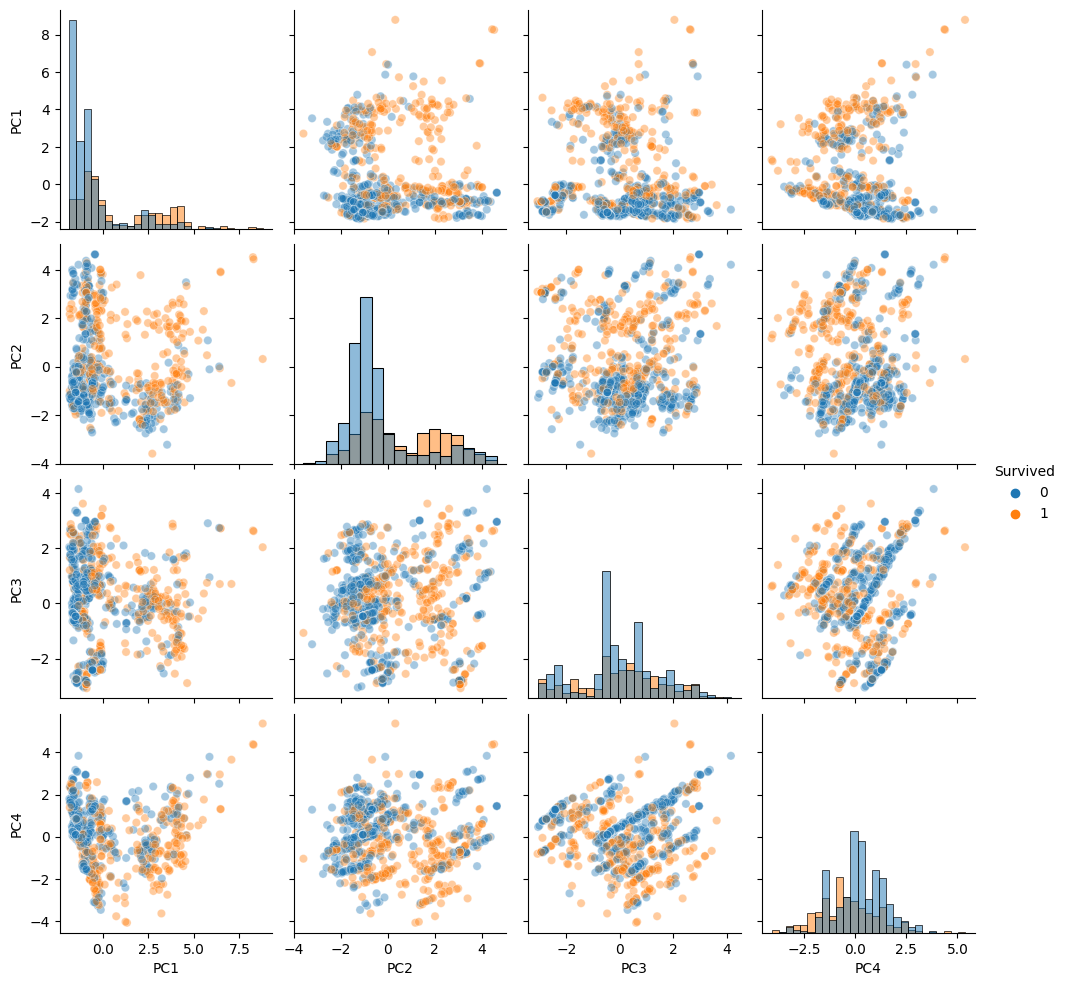

In [32]:
titanic_pca = pd.DataFrame( principal_axes, columns=['PC1', 'PC2', 'PC3', 'PC4'] )
titanic_pca['Survived'] = train_data['Survived']

sns.pairplot(titanic_pca, kind='scatter', hue='Survived', diag_kind="hist", plot_kws=dict(alpha=0.4) )

We can see that there is a lot of mixing. In the $PC1-PC2$ plane there are some regions where the non-survivors are rare. However, whenever there are many non-survivors, we also see many survivors clustering in the same region.

Let us next see the loadings in the $PC1-PC2$ plane.

In [33]:
loadings12 = ( pca.components_.T * np.sqrt(pca.explained_variance_) )[:,:2]

In [34]:
def plot_loadings2D(pca_data, loadings_matrix, labels=None):
    xs = pca_data[:,0]
    ys = pca_data[:,1]
    n = loadings_matrix.shape[0]
    scalex = 1.0/(xs.max() - xs.min())
    scaley = 1.0/(ys.max() - ys.min())
    plt.scatter(xs * scalex,ys * scaley, c = 'yellow', alpha=0.4)
    for i in range(n):
        plt.arrow(0, 0, loadings_matrix[i,0], loadings_matrix[i,1],color = 'r',alpha = 0.5)
        if labels is None:
            plt.text(loadings_matrix[i,0]* 1.15, loadings_matrix[i,1] * 1.15, "Var"+str(i+1), color = 'g', ha = 'center', va = 'center')
        else:
            plt.text(loadings_matrix[i,0]* 1.15, loadings_matrix[i,1] * 1.15, labels[i], color = 'g', ha = 'center', va = 'center')
    plt.xlim(-1,1)
    plt.ylim(-1,1)
    plt.xlabel("PC{}".format(1))
    plt.ylabel("PC{}".format(2))
    plt.grid()

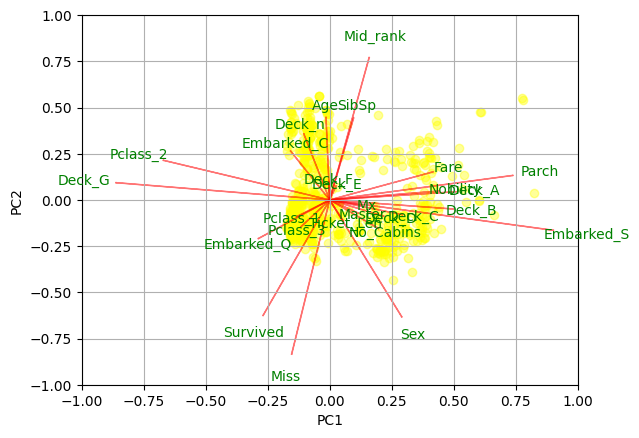

In [35]:
plot_loadings2D(principal_axes, loadings12, labels=list(train_data.columns[1:]))

Again, looks pretty messy. Remembering from the pairplot above that many survivors fall into the quadrant $PC1>0, PC2>0$ we can see that these people were probably some of the wealthy people on board. They came from nobility (or were "Mid_rank" which means doctors, military people, etc.), stayed at a high deck, paid a higher than average fare, were middle-aged, and got on board in Southampton (which probably also correlates with being wealthy).